# 전결합층 구현

### 공통 클래스 구현
- 은닉층과 출력층을 각 클래스로 구현하기에 앞서, 공통 부분을 BaseLayer 클래스로 구현한다.

In [2]:
import pandas as pd
import numpy as np

In [3]:
# -- 전결합층의 부모 클래스 --
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

- BaseLayer 클래스를 update 메소드로 구현함.
- 이 메소드에 최적화 알고리즘을 구현하기 위해 SGD(확률적 경사 하강법)을 구현한다.

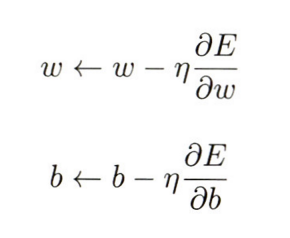

- 이 식에서 학습률은 update 메소드의 eta값.
- self.가 붙어있는 변수는 다른 메소드나 외부와 공유하는 변수
- 아다그라드(AdaGrad)나 아담(Adam)등의 최적화 알고리즘을 구현할 때는 이 BaseLayer 클래스를 조금 변경한다.

### 은닉층 구현
- 은닉층을 구현하기 위한 예이다.
- 초기화를 위해 __init__ 메소드, 순전파를 위한 forward 메소드, 역전파를 위한 backward 메소드를 포함한다.

In [4]:
# -- 은닉층 --
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # He 초깃값
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)   # ReLU

    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)    # ReLU 미분

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

#### __init__메소드
- n_upper는 앞 층의 뉴런 수, n은 해당 층의 뉴런 수이다.
- 가중치 self.w의 초깃값은 평균이 0이고 표준편차가 다음과 같은 식으로 표현되는 **He 초깃값**을 사용한다.

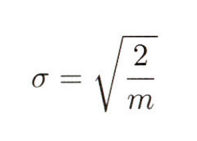

- $m$은 앞 층의 뉴런 수
- He 초깃값은 활성화 함수가 ReLU일 때, 여러 층을 거쳐도 값에 편향이 생기기 어렵다고 알려져 있다.

#### forward 메소드
- 활성화 함수로 다음과 같은 ReLU를 사용한다.

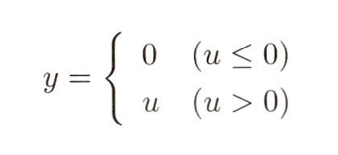

- ReLU는 forward 메소드 안에 where 함수를 사용해 구현한다.

#### backward 메소드
- 다음 식을 이용해 delta를 계산한다.

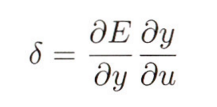

- 우변은 출력 기울기와 활성화 함수를 편미분한 것(편도함수)의 곱으로서, 코드에서는 인수인 grad_y가 출력 기울기
- 활성화 함수인 ReLU의 편도함수는 다음과 같다.

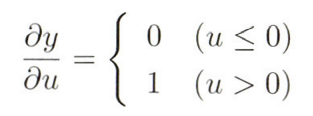

- where 함수를 이용해 코드로 구현할 수 있다.
```
np.where(self.u <= 0, 0, 1)
```
- grad_y와 이 코드 결괏값의 곱셈으로 delta를 구하고, 이후에 이 값을 이용해 각 기울기를 계산하는 과정이 이어진다.

### 출력층 구현
- 출력층을 구현한다.
- 은닉층과 마찬가지로 초기화를 위해 __init__ 메소드, 순전파를 위한 forward 메소드, 역전파를 위한 backward 메소드를 포함한다.

In [5]:
# OutputLayer 클래스
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        # 소프트맥스 함수
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)     # 이 코드는 소프트맥스 함수식을 직관적으로 잘 표현한 코드이지만, 지수함수의 특성상 입력값이 커지면 컴퓨터의 계산 범위를 벗어나 프로그램이 멈추는 오버플로우 문제 발생

    def backward(self, t):
        delta = self.y - t

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

#### __init__ 메소드
- 가중치 self.w의 초깃값에 다음 식과 같은 표준편차 값을 가지는 '자비에르(Xavier) 초기화 기반의 초깃값'을 사용한다.

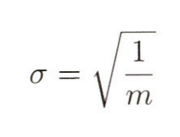

- $m$은 앞 층의 뉴런 수이다.
- 자비에르 초기화 기반의 초깃값은 활성화 함수가 좌우대칭일 경우 값의 편차가 커지는 것을 방지한다고 알려져 있다.

#### forward 메소드
- 다음 식으로 표현되는 소프트맥스 함수를 활성화 함수로 이용한다.

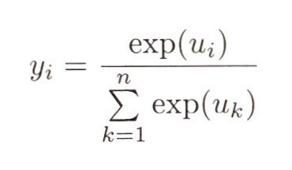

- 이 식에서 $n$은 이 층의 뉴런 수이며, 첨자는 해당 층 뉴런의 인덱스를 의미한다.
- 소프트맥스 함수의 출력값 $y_i$는 반드시 0보다 크며 층의 모든 뉴런에서 총합을 구하면 값이 1이므로, 확률을 표현하는 데 소프트맥스 함수가 자주 사용된다.
- 코드에서는 넘파이의 sum 함수를 이용해 소프트맥스 함수를 구현하는데, axis=1로 지정하고 샘플마다 총합을 구하고, keepdims = True로 지정해 배열의 차원을 유지한다.

#### backward 메소드
- 출력 기울기와 활성화 함수의 편도함수 곱을 이용해 delta를 계산한다.
- 활성화 함수인 소프트맥스 함수의 편도함수는 다음 수식과 같다.

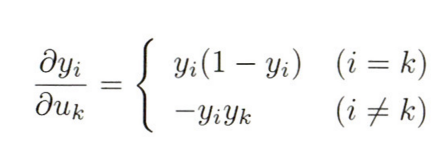

- 예제 코드는 다수의 클래스를 분류하는 문제이므로 교차 엔트로피 오차를 오차 함수로 사용한다.

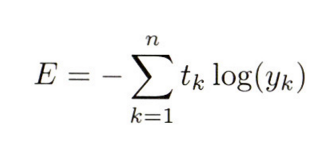

- 여기에서 $y_k$는 출력, $t_k$는 각 출력에 대응하는 정답이다.
- 이를 이용해 $δ_i$를 다음과 같이 구할 수 있다.

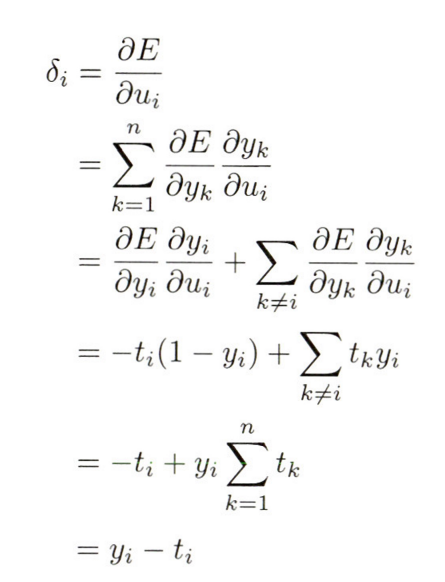

- 수식을 전개하면 결과적으로 $δ_i$ = $y_i$ - $t_i$가 된다.
- backward 메소드에서는 제일 처음 이 값을 구하고 각 기울기를 계산한다.